### Performs the continuous vector embedding of MassBank & GNPS molecules (trained on Pubchem 500k data)

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import pickle
import glob
import pprint
import requests

import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults

import pubchempy as pcp
from keras.models import Sequential, Model, load_model

Using TensorFlow backend.


In [3]:
np.random.seed(seed=1234)

In [4]:
import sys
sys.path.append('..')

from molecules.model import MoleculeVAE, SimpleMoleculeVAE
from molecules.utils import one_hot_array, one_hot_index, from_one_hot_array, \
    decode_smiles_from_indexes, load_dataset
    
sys.path.append('/data/lda/code/')
from classyfire_interface import get_taxa_path_and_substituents

In [5]:
# from embedding import to_one_hot_array, get_input_arr, autoencode, encode
# from embedding import visualize_latent_rep, get_classifyre, get_scatter_colours
# from embedding import make_plot

#### Load MassBank & GNPS data

In [6]:
def fetch_or_load(ms2lda_url, data_file):

    if len(glob.glob(data_file)) > 0:
        print "Loading %s from file" % data_file
        with open(data_file,'r') as f:
            data = pickle.load(f)
    else:
        print "Fetching %s from server" % data_file
        r = requests.get(ms2lda_url)
        data = r.json()
        with open(data_file,'w') as f:
            pickle.dump(data,f)

    return data

In [7]:
def load_data(data):

    experiment_ids = {'gnps':191, 'massbank':190}
    doc_data_file = data + '_docs_data.dict'
    doc_metadata_file = data + '_docs_metadata.dict'
    
    ms2lda_url = 'http://ms2lda.org/basicviz/get_all_parents_metadata/{}/'.format(experiment_ids[data])    
    metadata = fetch_or_load(ms2lda_url, doc_metadata_file)
    
    ms2lda_url = 'http://ms2lda.org/basicviz/get_all_doc_data/{}/'.format(experiment_ids[data])    
    doc_data = fetch_or_load(ms2lda_url, doc_data_file)
    
    return metadata, doc_data

In [8]:
data = 'massbank'
massbank_metadata, massbank_doc_data = load_data(data)

Loading massbank_docs_metadata.dict from file
Loading massbank_docs_data.dict from file


In [9]:
data = 'gnps'
gnps_metadata, gnps_doc_data = load_data(data)

Loading gnps_docs_metadata.dict from file
Loading gnps_docs_data.dict from file


In [10]:
# pp = pprint.PrettyPrinter(depth=4)
# pp.pprint(massbank_doc_data[0])
# pp.pprint(massbank_metadata[0])

#### Load VAE model

In [11]:
data_file = '/data/joe-keras/keras-molecules/preprocessed/pubchem_500k.h5'
model_file = '/data/joe-keras/keras-molecules/models/pubchem_500k.h5'
latent_dim = 100
# data_file = '/data/joe-keras/original/keras-molecules/data/processed.h5'
# model_file = '/data/joe-keras/keras-molecules/models/smiles_500k.h5'
# latent_dim = 292

In [12]:
import h5py

In [13]:
def load_dataset_charset_only(filename, split = True):
    h5f = h5py.File(filename, 'r')
    if split:
        data_train = h5f['data_train'][:]
    else:
        data_train = None
#     data_test = h5f['data_test'][:]
    charset =  h5f['charset'][:]
    h5f.close()
    if split:
        return (data_train, data_test, charset)
    else:
        return charset


In [14]:
charset = load_dataset_charset_only(data_file, split = False)

In [15]:
print charset, len(charset)

[' ' '(' '.' '0' '2' '4' '6' '8' 'B' 'D' 'F' 'H' 'L' 'N' 'P' 'R' 'T' 'V'
 'Z' 'b' 'd' 'f' 'h' 'l' 'n' 'p' 'r' 't' '#' '%' ')' '+' '-' '1' '3' '5'
 '7' '9' '=' 'A' 'C' 'E' 'G' 'I' 'K' 'M' 'O' 'S' 'U' 'W' 'Y' '[' ']' 'a'
 'c' 'e' 'g' 'i' 'm' 'o' 's' 'u' 'y'] 63


In [16]:
model = SimpleMoleculeVAE()
model.load(charset, model_file, latent_rep_size=latent_dim)

In [17]:
def to_one_hot_array(smile_str, charset, max_char=120):
        
    filtered = []
    for c in smile_str:
        if c in charset:
            filtered.append(c)
            if len(filtered) == max_char:
                break            

    charset_list = charset.tolist()    
    one_hot_encoded_fn = lambda row: map(lambda x: one_hot_array(x, len(charset_list)),
                                                one_hot_index(row, charset_list))

    filtered_str = ''.join(filtered)
    filtered_str = filtered_str.ljust(max_char) # pad up to max_char
    filtered_arr = np.array(one_hot_encoded_fn(filtered_str))
    return filtered_arr

In [18]:
def get_input_arr(smiles_list, charset):
    
    input_arr = []
    for i in range(len(smiles_list)):
        smile = smiles_list[i]
        one_hot_encoded = to_one_hot_array(smile, charset)
        input_arr.append(one_hot_encoded)

    input_arr = np.array(input_arr)
    return input_arr

In [19]:
def autoencode(model, charset, input_array, N=100):    

    for pos in range(len(input_array)):

        sampled = model.autoencoder.predict(input_array[pos].reshape(1, 120, len(charset))).argmax(axis=2)[0]
        mol = decode_smiles_from_indexes(map(from_one_hot_array, input_array[pos]), charset)
        sampled = decode_smiles_from_indexes(sampled, charset)

        print 'i>', mol
        print 'o>', sampled
        print
        
        if pos > N:
            break

In [20]:
def encode(model, input_array):
    
    x_latent = model.encoder.predict(input_array)
    return x_latent

#### MassBank Embedding

In [21]:
def visualize_latent_rep(data, model, latent_dim, colours=None, hide=False):
    
    PCA_COMPONENTS = 50
    TSNE_LEARNING_RATE = 750.0
    TSNE_ITERATIONS = 1000
    TSNE_COMPONENTS = 2
    TSNE_PERPLEXITY = 30.0    
    
    print("pca_comp=%d tsne_comp=%d tsne_perplexity=%f tsne_lr=%f" % (
        PCA_COMPONENTS,
        TSNE_COMPONENTS,
        TSNE_PERPLEXITY,
        TSNE_LEARNING_RATE
    ))

    if colours and hide: # exclude those with no classifyre type from the plot
        assert len(data) == len(colours)
        new_data = []
        new_colours = []
        for i in range(len(data)):
            if colours[i] != 0: # 0 is for None
                new_data.append(data[i])
                new_colours.append(colours[i])
        data = np.array(new_data)
        colours = np.array(new_colours) - 1
    
    pca = PCA(n_components = PCA_COMPONENTS)
    x_latent = model.encoder.predict(data)    
    x_latent = pca.fit_transform(x_latent)
    covariance = pca.get_covariance()

    evr = pca.explained_variance_ratio_
    print evr
    print 'Explained variations -- first two PCs: %.2f' % (evr[0] + evr[1])
    print 'Explained variations -- all components: %.2f' % np.sum(evr)

    plt.figure(figsize=(12, 12))
    if colours is not None:
        cmap = plt.cm.jet
        plt.scatter(x_latent[:, 0], x_latent[:, 1], marker='.', c=colours, cmap=cmap, alpha=0.5)
        plt.colorbar()
    else:
        plt.scatter(x_latent[:, 0], x_latent[:, 1], marker='.')
        
    plt.title('PCA - Latent Dim %d' % latent_dim)
    plt.show()
    
    return x_latent, covariance, pca

#     tsne = TSNE(n_components = TSNE_COMPONENTS,
#                 perplexity = TSNE_PERPLEXITY,
#                 learning_rate = TSNE_LEARNING_RATE,
#                 n_iter = TSNE_ITERATIONS,
#                 verbose = 4)
#     x_latent_proj = tsne.fit_transform(x_latent)
#     del x_latent

#     plt.figure(figsize=(16, 16))
#     if colours is not None:
#         cmap = plt.cm.jet
#         plt.scatter(x_latent_proj[:, 0], x_latent_proj[:, 1], marker='.', c=colours, cmap=cmap)
#         plt.colorbar()
#     else:
#         plt.scatter(x_latent_proj[:, 0], x_latent_proj[:, 1], marker='.')
#     plt.title('tSNE - Latent Dim %d' % latent_dim)    
#     plt.show()

In [22]:
def get_classifyre(inchikeys, out_file=None):

    if len(glob.glob(out_file)) > 0:
        print "Loading %s from file" % out_file
        with open(out_file,'r') as f:
            data = pickle.load(f)
            taxa = data[0]
            subs = data[1]
    else:

        print "Fetching %s from server" % out_file
        taxa = {}
        subs = {}
        for i in range(len(inchikeys)):
            if i % 100 == 0:
                print '%d/%d' % (i, len(inchikeys))
            inchikey = inchikeys[i]
            taxa_path, substituents = get_taxa_path_and_substituents(inchikey)
            taxa[inchikey] = taxa_path
            subs[inchikey] = substituents

        data = (taxa, subs,)
        with open(out_file,'w') as f:
            pickle.dump(data, f)
    
    return taxa, subs

In [23]:
def get_scatter_colours(inchikeys, taxa_path):
    
    superclasses = []
    for inchikey in inchikeys:
        if inchikey in taxa_path:
            t = taxa_path[inchikey]
            if len(t) > 0:
                superclass = t[1] # kingdom, superclass, class, subclass ...
            else:
                superclass = None
        else:
            superclass = None
        superclasses.append(superclass)
        
    unique_superclasses = sorted(list(set(superclasses)))
    superclass_idx = {}
    for i, x in enumerate(unique_superclasses):
        superclass_idx[x] = i
        print i, x

    superclasses_idx = [superclass_idx[sp] for sp in superclasses]
    return superclasses_idx

In [24]:
massbank_smiles = [m['smiles'] for m in massbank_metadata]
massbank_inchikeys = [m['InChIKey'] for m in massbank_metadata]

Note:
- The canonical SMILES are calculated using Accelrys's Pipeline Pilot using an algorithm that belongs to Accelrys but it was derived from Daylight's algorithm (http://www.daylight.com/dayhtml/doc/theory/theory.smiles.html). The standard InChI is calculated using the command line InChI generator and was developed by the InChI Trust (http://www.inchi-trust.org/inchi/) and is called up via the command line (https://www.ebi.ac.uk/chembl/faq#faq28).
- https://sourceforge.net/p/cdk/mailman/message/2975484/

In [25]:
massbank_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(str(x))) for x in massbank_smiles]
input_array = get_input_arr(massbank_smiles, charset)
massbank_latent = encode(model, input_array)

In [26]:
# autoencode(model, charset, input_array, N =3)

### parentmass plot

pca_comp=50 tsne_comp=2 tsne_perplexity=30.000000 tsne_lr=750.000000
[  7.74111661e-01   7.37997808e-02   2.94908964e-02   2.27124369e-02
   1.35235791e-02   1.27105571e-02   1.05791769e-02   8.89165574e-03
   7.07578975e-03   5.83392082e-03   4.13326094e-03   3.74276125e-03
   3.57545841e-03   2.72535688e-03   2.62019119e-03   2.36593050e-03
   2.04267221e-03   1.64676073e-03   1.58982414e-03   1.42803349e-03
   1.32090784e-03   1.08356875e-03   8.94608074e-04   8.72108002e-04
   7.90825395e-04   6.54590686e-04   6.35940359e-04   5.54230887e-04
   5.11023521e-04   4.20326121e-04   3.78338506e-04   3.74094952e-04
   3.25892658e-04   3.04625134e-04   2.95502765e-04   2.62039851e-04
   2.24750032e-04   2.16407932e-04   1.85982785e-04   1.72725536e-04
   1.65194167e-04   1.64050016e-04   1.53258248e-04   1.23521738e-04
   1.13929294e-04   1.07819758e-04   1.05277344e-04   1.02045902e-04
   9.94363731e-05   9.40620298e-05]
Explained variations -- first two PCs: 0.85
Explained variations --

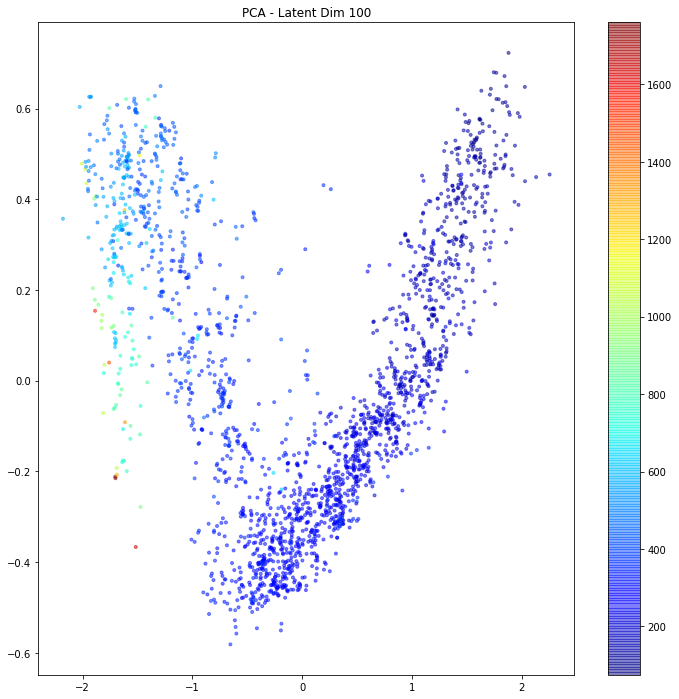

In [27]:
parentmass_idx = [float(massbank_metadata[i]['parentmass']) for i in range(len(massbank_metadata))]
x_latent, covariance, pca = visualize_latent_rep(input_array, model, latent_dim, colours=parentmass_idx)

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(massbank_latent, parentmass_idx, test_size=0.33, random_state=42)

In [30]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print mean_squared_error(y_test, lr.predict(X_test))

3182.83577005


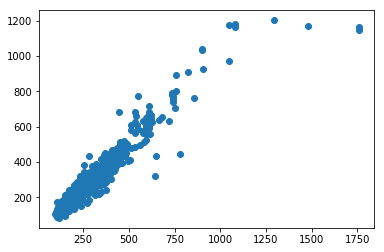

In [31]:
plt.scatter(y_test, lr.predict(X_test))

In [32]:
## Useless
# def getBinnedFeatures(massbank_doc_data):
#     n = len(massbank_doc_data)
#     myBinnedData = [[0 for i in range(2000)] for j in range(n)]
#     for i in range(n):
#         for (frag, intensity) in massbank_doc_data[i][1]:
#             mass = float(frag.split("_")[1])
#             nominal_mass = int(round(mass))

#             if frag.startswith("fragment"):
#                 idx = nominal_mass - 1
#             else:
#                 idx = nominal_mass - 1 + 1000
            
#             myBinnedData[i][idx] = myBinnedData[i][idx] + intensity
#     return myBinnedData
                
    
    

In [33]:
# mylist = []
# for i in range(len(massbank_doc_data)):
#     for (frag, intensity) in massbank_doc_data[i][1]:
#         if frag.startswith("frag"):
#             mylist.append(float(frag.lstrip("fragment_")))

In [34]:
# aa = getBinnedFeatures(massbank_doc_data)

In [35]:
def visualize_data_with_motifname(motif_name, doc_data, input_array, threshold = 0.0, annotation = ""):
    idx = []
    n = len(doc_data)
    for i in range(n):
        for (motif, prob, overlap) in doc_data[i][2]:
            if motif == motif_name and prob > threshold:
                idx.append(i)
    print idx
    
    PCA_COMPONENTS = 50
    TSNE_LEARNING_RATE = 750.0
    TSNE_ITERATIONS = 1000
    TSNE_COMPONENTS = 2
    TSNE_PERPLEXITY = 30.0    

#     print("pca_comp=%d tsne_comp=%d tsne_perplexity=%f tsne_lr=%f" % (
#         PCA_COMPONENTS,
#         TSNE_COMPONENTS,
#         TSNE_PERPLEXITY,
#         TSNE_LEARNING_RATE
#     ))

    pca = PCA(n_components = PCA_COMPONENTS)
    x_latent = model.encoder.predict(input_array)    
    x_latent = pca.fit_transform(x_latent)
    covariance = pca.get_covariance()

    evr = pca.explained_variance_ratio_
#     print evr
#     print 'Explained variations -- first two PCs: %.2f' % (evr[0] + evr[1] + evr[2])
#     print 'Explained variations -- all components: %.2f' % np.sum(evr)
    
    plt.figure(figsize=(12, 12))
    plt.scatter(x_latent[:, 0], x_latent[:, 1], marker='.', s = 20)
    plt.scatter(x_latent[idx, 0], x_latent[idx, 1], marker='+', s = 150)
    
#     print latent_dim, motif_name, annotation
    plt.title('PCA - Latent Dim {} with {}: {}'.format(latent_dim, motif_name, annotation))
    plt.show()



In [36]:
test_dict = {
    "motif_14": 'Combination of small losses (i.e. NH3 and CH2O2)',
    "motif_10": 'Loss of C3H6 - indicative for the presence of an isopropyl group',
    "motif_32": 'Fragments indicative for ferulic acid based substructure (MzCloud)',
    "motif_28": 'Fragment ions indicative for C6H12NO substructure (in beer related to N-acetylputrescine - MzCloud)',
    "motif_24": 'Fragments indicative of a glycosylation - i.e. indicative for a sugar conjugation (in beer often related to glucose)',
    "motif_18": 'CO loss - indicative for presence of ketone/aldehyde/lactone group (C=O)',
    "motif_34": 'Double water loss i.e. 2*H20  Generic feature for metabolites containing several free OH groups attached to a aliphatic chain like sugars.',
    "motif_13": 'Alkyl aromatic substructure   indicative for aromatic ring with 2-carbon alkyl chain attached i.e. phenylethene fragment from ethylbenzene as a result of the fragmentation process.',
    "motif_24": 'Fragments indicative of a glycosylation - i.e. indicative for a sugar conjugation (in beer often related to glucose)',
    "motif_41": 'Loss indicative of [hexose-H20]'
}

[351, 501, 637, 1266, 1372, 1485, 1748]


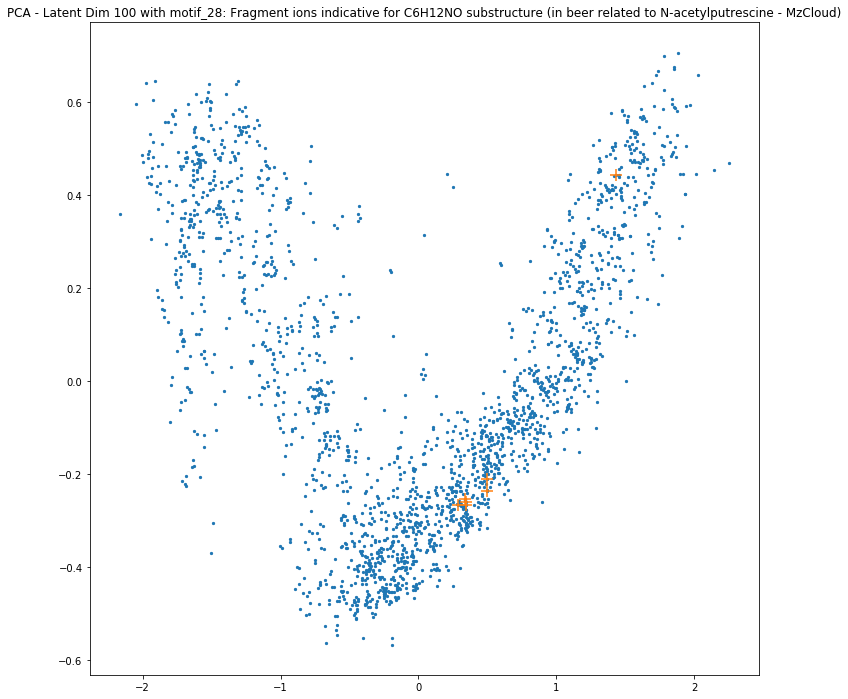

[587, 698, 1265, 1387]


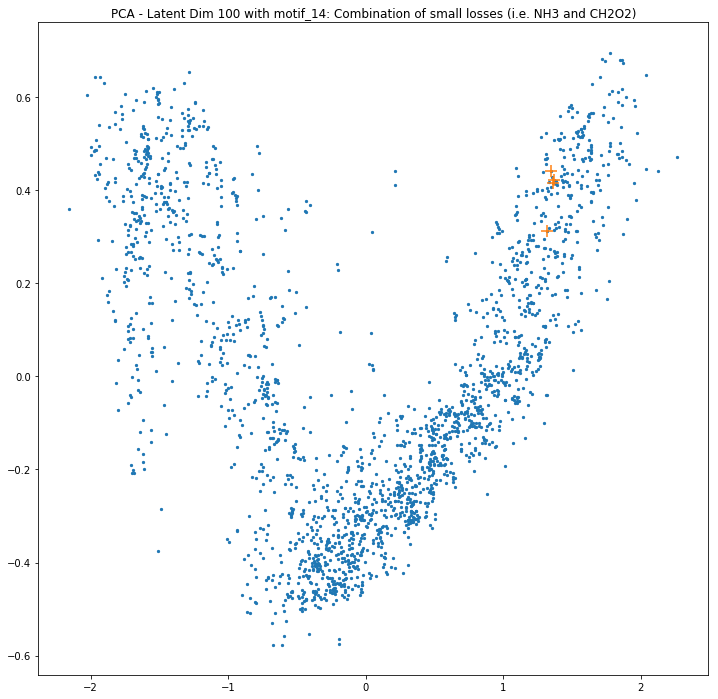

[1663]


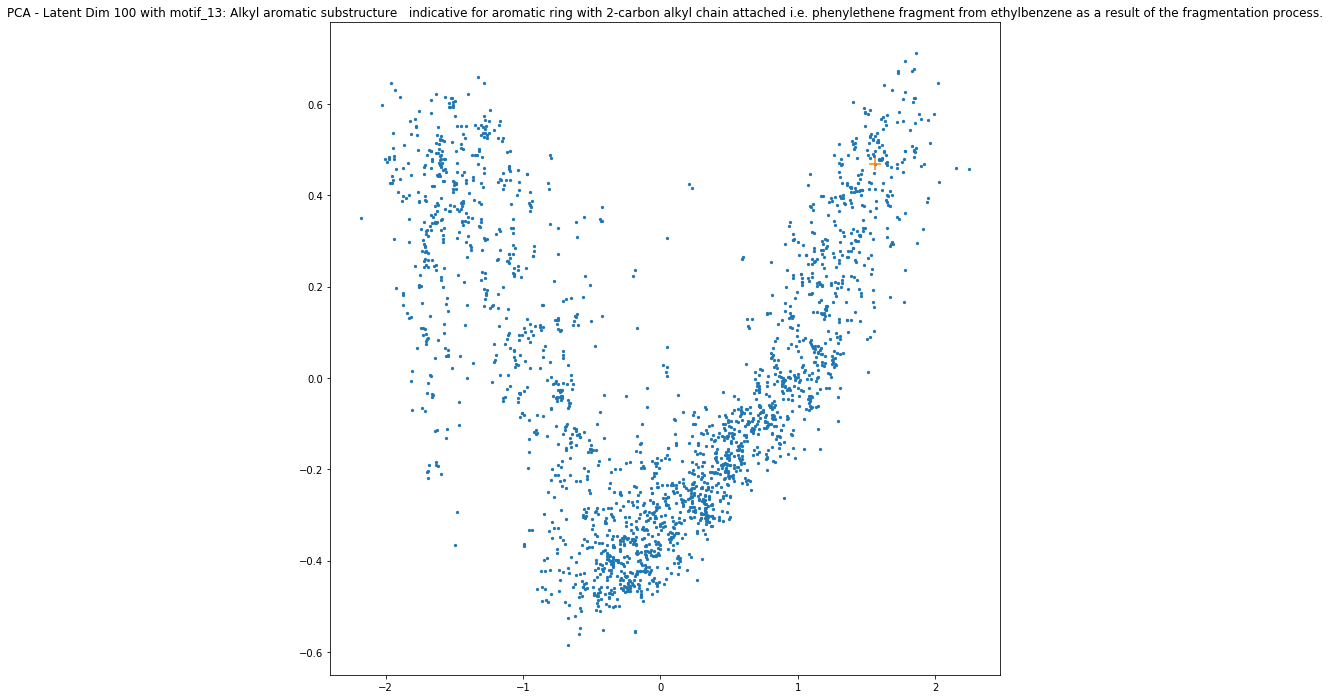

[83, 170, 259, 290, 451, 520, 976, 1169, 1403, 1449, 1522, 1743, 1777, 1791, 1834, 1903]


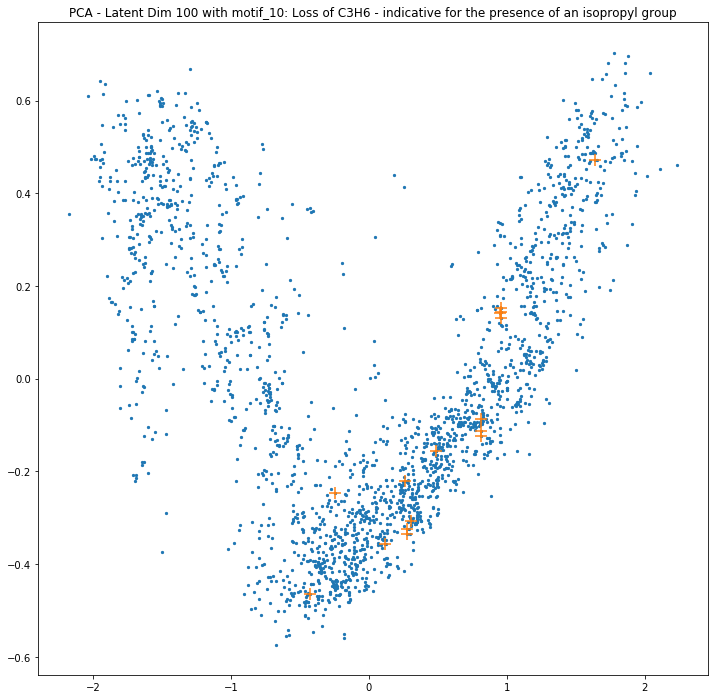

[1, 20, 82, 101, 107, 122, 237, 266, 269, 295, 298, 360, 408, 484, 582, 666, 771, 784, 894, 958, 1041, 1125, 1135, 1432, 1481, 1554, 1622, 1698, 1707, 1789, 1965]


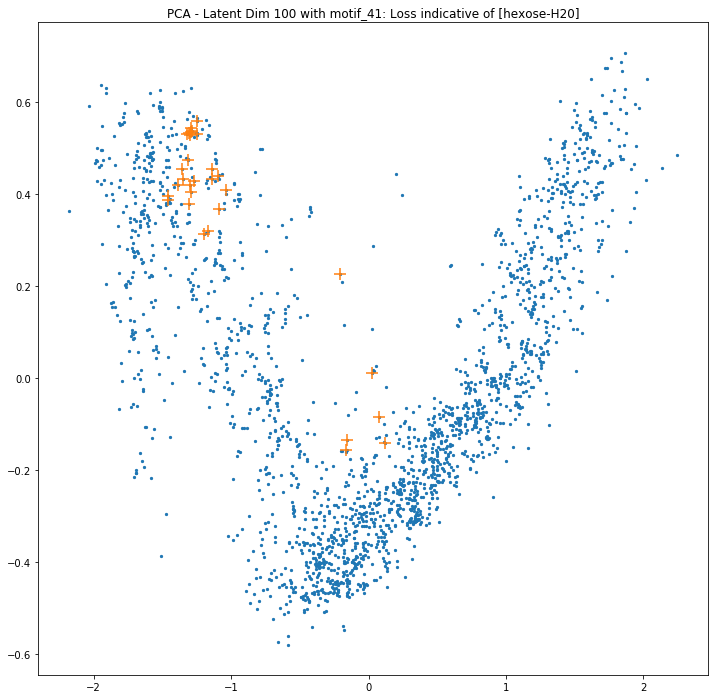

[]


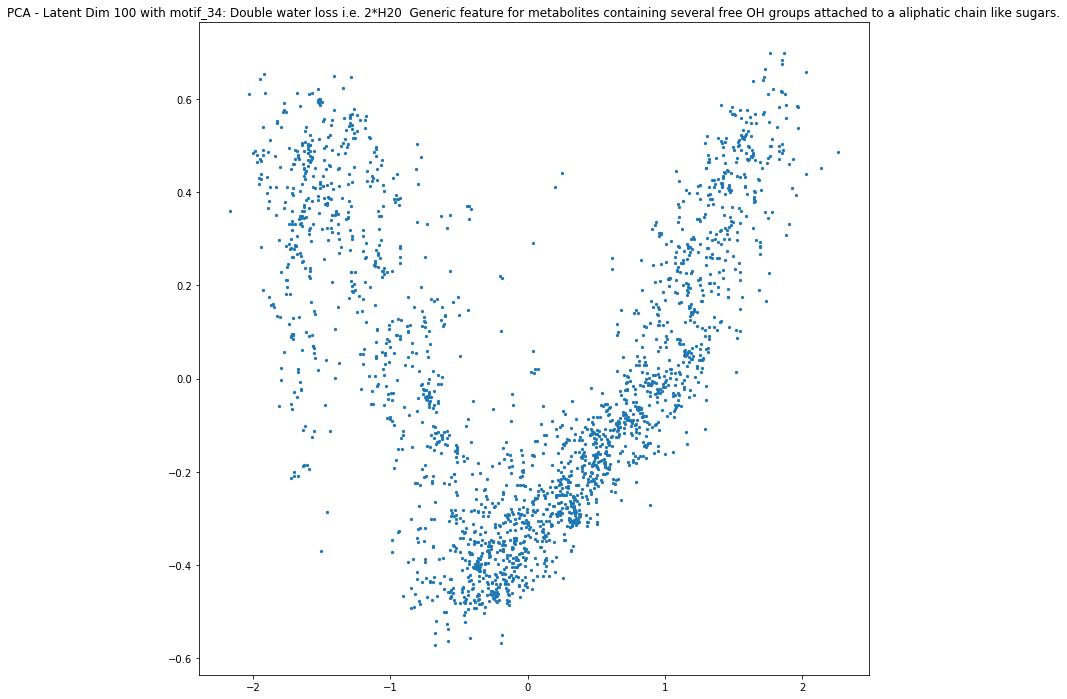

[]


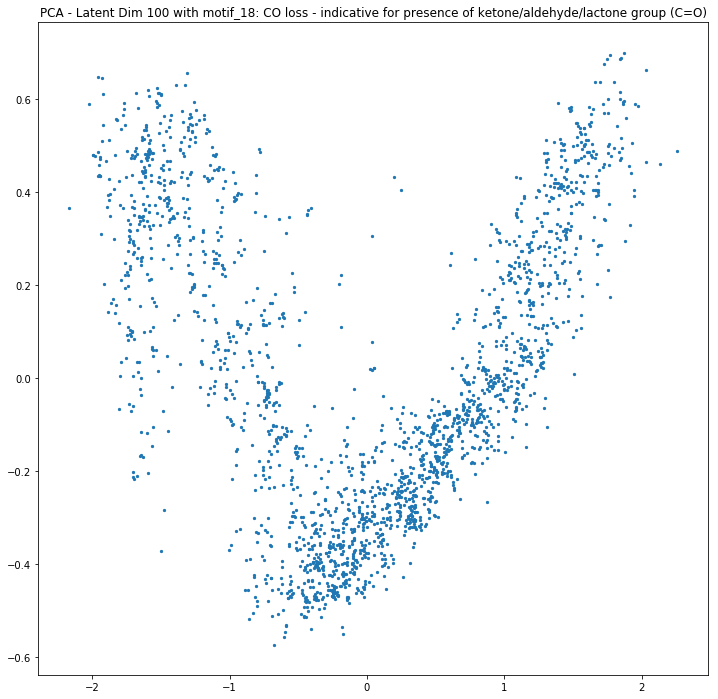

[37, 738]


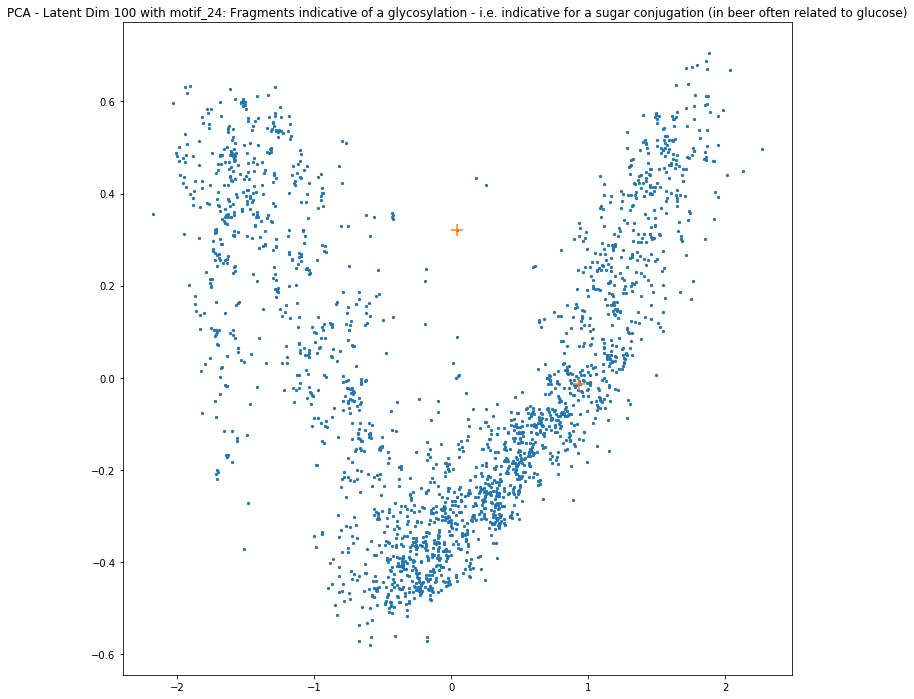

[260, 816, 1240, 1802]


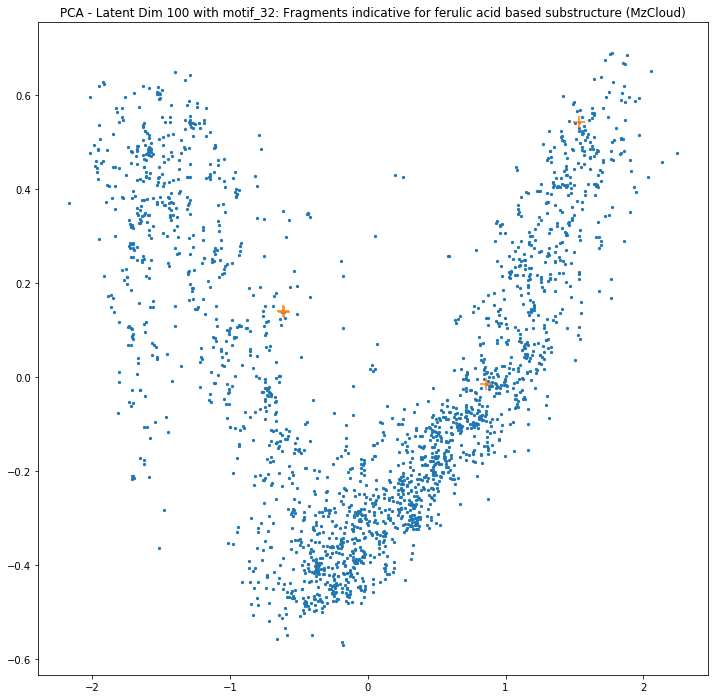

In [37]:
for k,v in test_dict.items():
    visualize_data_with_motifname(k, massbank_doc_data, input_array, threshold = 0.3, annotation = v)

In [39]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
def visualize_data_with_motifname_3d(motif_name, doc_data, input_array, threshold = 0.3):
    idx = []
    n = len(doc_data)
    for i in range(n):
        for (motif, prob, overlap) in doc_data[i][2]:
            if motif == motif_name and prob > threshold:
                idx.append(i)
    print idx
    
    PCA_COMPONENTS = 50
    TSNE_LEARNING_RATE = 750.0
    TSNE_ITERATIONS = 1000
    TSNE_COMPONENTS = 2
    TSNE_PERPLEXITY = 30.0    

    print("pca_comp=%d tsne_comp=%d tsne_perplexity=%f tsne_lr=%f" % (
        PCA_COMPONENTS,
        TSNE_COMPONENTS,
        TSNE_PERPLEXITY,
        TSNE_LEARNING_RATE
    ))

    pca = PCA(n_components = PCA_COMPONENTS)
    x_latent = model.encoder.predict(input_array)    
    x_latent = pca.fit_transform(x_latent)
    covariance = pca.get_covariance()

    evr = pca.explained_variance_ratio_
#     print evr
#     print 'Explained variations -- first two PCs: %.2f' % (evr[0] + evr[1]+evr[2])
#     print 'Explained variations -- all components: %.2f' % np.sum(evr)
    
    colours = [0 for i in range(len(doc_data))]
    for i in idx:
        colours[i] = 1
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x_latent[:, 0], x_latent[:, 1], x_latent[:, 2], marker='.', s = 20, c= colours)



[1, 2, 20, 82, 92, 101, 107, 109, 122, 151, 218, 228, 237, 266, 269, 295, 298, 315, 355, 360, 379, 408, 417, 484, 582, 666, 771, 774, 784, 894, 911, 958, 1006, 1041, 1044, 1097, 1125, 1135, 1149, 1282, 1432, 1481, 1554, 1622, 1698, 1707, 1789, 1965, 2093]
pca_comp=50 tsne_comp=2 tsne_perplexity=30.000000 tsne_lr=750.000000


<IPython.core.display.Javascript object>


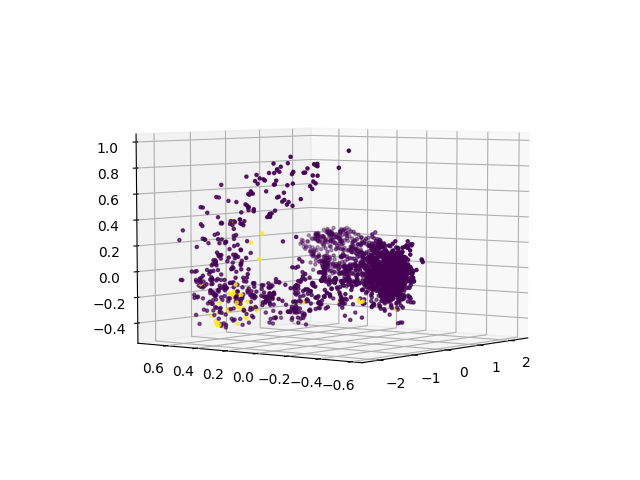

In [41]:
visualize_data_with_motifname_3d("motif_41", massbank_doc_data, input_array, 0.1)

[1, 20, 82, 101, 107, 122, 237, 266, 269, 295, 298, 360, 408, 484, 582, 666, 771, 784, 894, 958, 1041, 1125, 1135, 1432, 1481, 1554, 1622, 1698, 1707, 1789, 1965]
pca_comp=50 tsne_comp=2 tsne_perplexity=30.000000 tsne_lr=750.000000


<IPython.core.display.Javascript object>


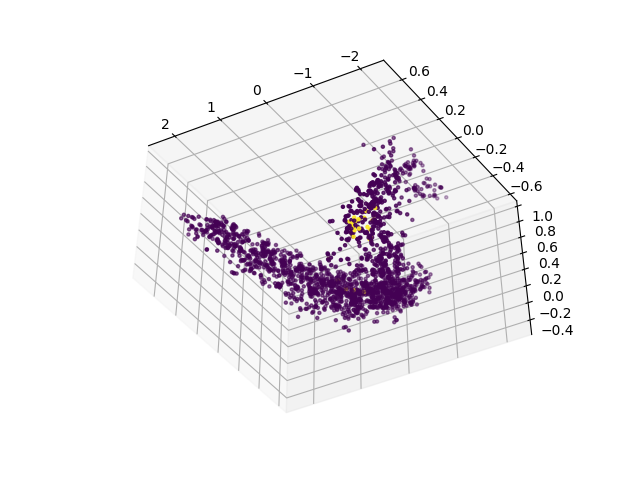

In [43]:
visualize_data_with_motifname_3d("motif_41", massbank_doc_data, input_array, 0.3)

## gnps test

In [44]:
gnps_smiles = [m['smiles'] for m in gnps_metadata]
gnps_inchikeys = [m['InChIKey'] for m in gnps_metadata]

In [45]:
gnps_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(str(x))) for x in gnps_smiles]
input_array = get_input_arr(gnps_smiles, charset)
gnps_latent = encode(model, input_array)

In [46]:
%matplotlib inline

pca_comp=50 tsne_comp=2 tsne_perplexity=30.000000 tsne_lr=750.000000
[  7.24009520e-01   7.89513885e-02   4.39984775e-02   2.48957096e-02
   1.98758083e-02   1.38282654e-02   1.14092067e-02   9.59925411e-03
   7.72296434e-03   7.52846071e-03   5.76296193e-03   5.52180105e-03
   4.76463705e-03   4.41542558e-03   3.55949381e-03   3.12037929e-03
   2.91641374e-03   2.62615884e-03   2.45115005e-03   2.18606223e-03
   1.94849916e-03   1.87747461e-03   1.70045539e-03   1.34141061e-03
   1.23469782e-03   1.12551059e-03   9.43364284e-04   8.70170971e-04
   8.17776026e-04   7.18969041e-04   6.09612895e-04   4.80098356e-04
   3.92073347e-04   3.67259606e-04   3.53767392e-04   3.16842787e-04
   2.32063490e-04   2.02822436e-04   1.92739676e-04   1.72396322e-04
   1.50770142e-04   1.45935814e-04   1.32751155e-04   1.29210150e-04
   1.18742343e-04   1.05534913e-04   1.00385923e-04   9.40286826e-05
   9.21666695e-05   9.02606982e-05]
Explained variations -- first two PCs: 0.80
Explained variations --

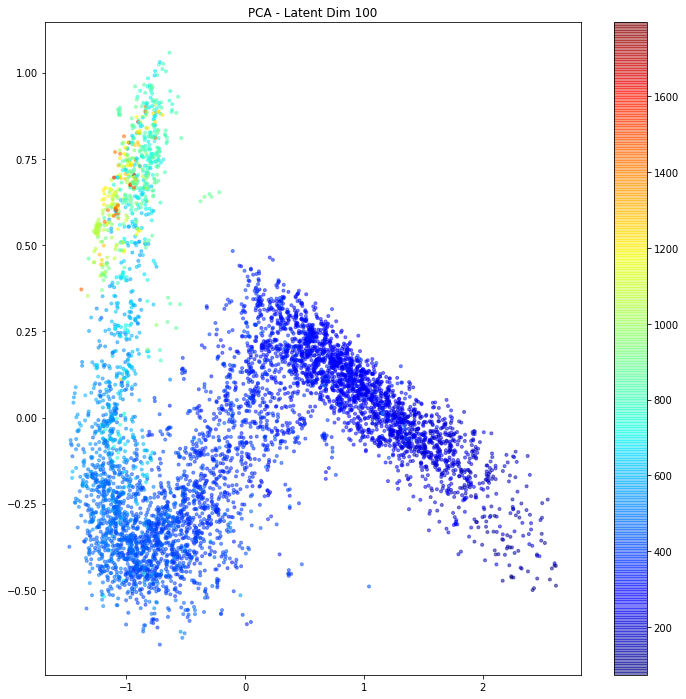

In [47]:
parentmass_idx = [float(gnps_metadata[i]['parentmass']) for i in range(len(gnps_metadata))]
x_latent, covariance, pca = visualize_latent_rep(input_array, model, latent_dim, colours=parentmass_idx)

In [48]:
test_dict = {
    "motif_9": 'Isopropyl/propylamine substructure (loss based) or isopropyl/propyl side chain',
    "motif_60": 'Quinazolinol substructure (or formed after fragmentation event of dihydro analogue)',
    "motif_65": 'oxo-1,2,3,4-tetrahydrocyclopenta[c]chromen-7-yl substructure',
    "motif_62": '10-Deacetylbaccatin-III related substructure',
    "motif_41": 'N-acetyl-4-piperidinecarboxylic acid substructure',
    "motif_72": 'Diethylamino /dimethylaminoethyl substructure',
    "motif_170": 'methoxy-methylaminophenyl substructure',
    "motif_498": 'None',
    "motif_399": 'None',
    "motif_374": 'None'
}

In [41]:
%matplotlib inline

[2, 72, 808, 1024, 1029, 1120, 1265, 1412, 1554, 1611, 1773, 2005, 2140, 2576, 2605, 2608, 2919, 2921, 2999, 3123, 3334, 3484, 3621, 3693, 3762, 3866, 3881, 3919, 3941, 4101, 4135, 4277, 4537, 4592, 4874, 5119, 5134, 5474, 5540, 5575, 5578, 5702]


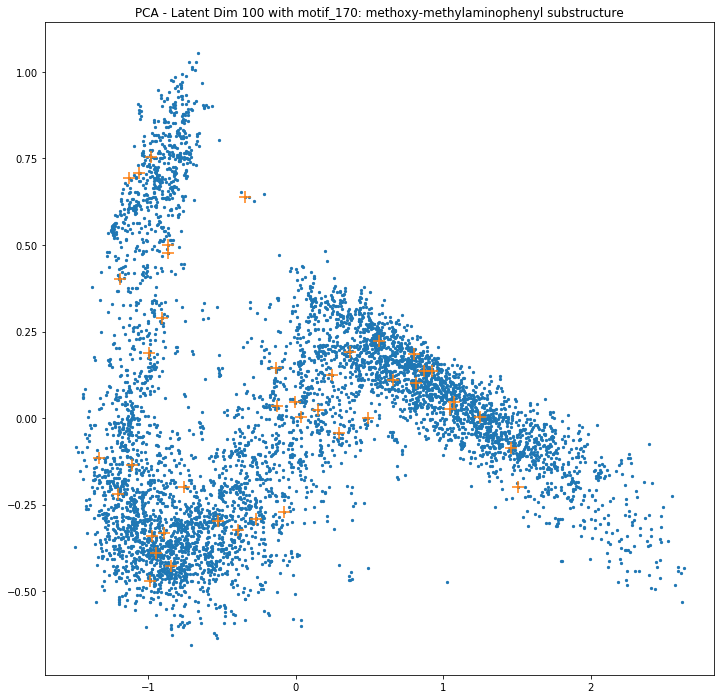

[360, 413, 991, 999, 1308, 1501, 1594, 1942, 2215, 3069, 3269, 3661, 3906, 4184, 5214, 5499]


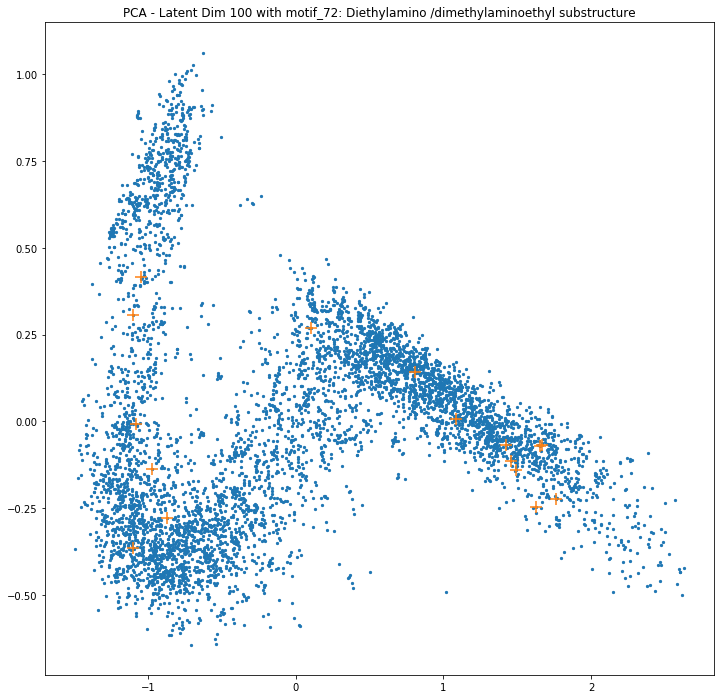

[89, 901, 915, 1248, 1520, 2366, 2527, 2632, 2730, 4046, 4168, 4315, 4909]


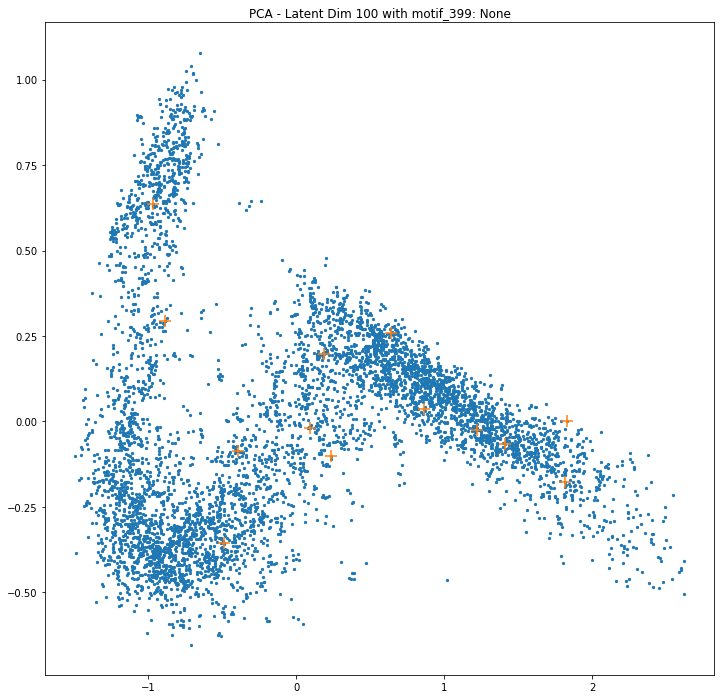

[821, 980, 1416, 1477, 1490, 1882, 2089, 2404, 2572, 2719, 2752, 2995, 3461, 3581, 4408, 4421, 4566, 5072, 5348, 5433]


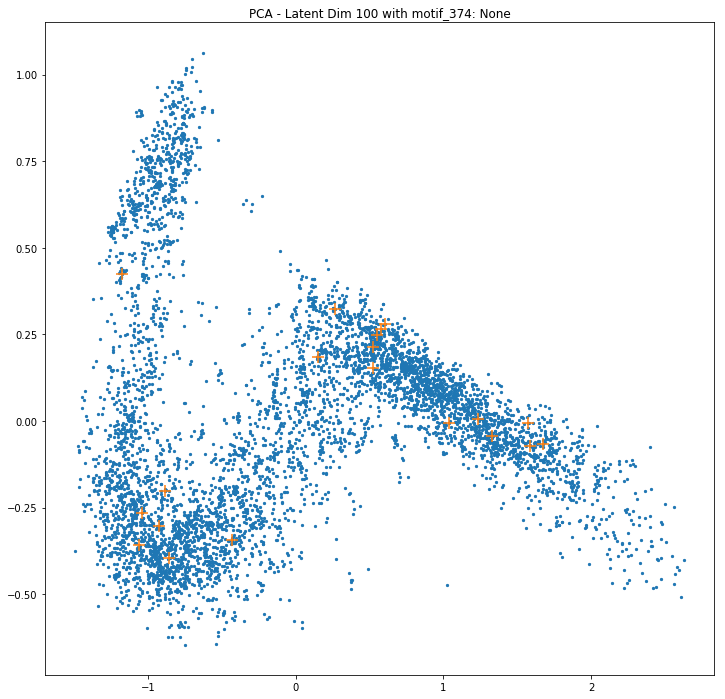

[172, 271, 905, 1093, 1173, 1235, 1369, 1408, 1489, 1562, 1656, 1686, 1822, 1939, 1976, 2449, 2547, 2801, 2859, 2868, 2938, 3122, 3351, 3353, 3829, 4090, 4236, 4283, 4388, 4641, 4778, 4885, 5024, 5108, 5654]


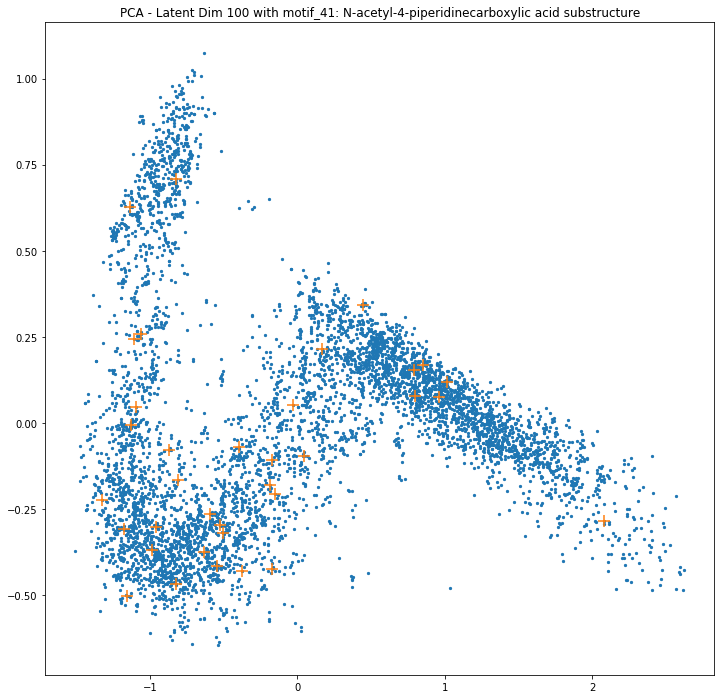

[38, 158, 489, 1071, 2183, 2196, 2583, 2627, 2672, 3185, 3756, 4083, 4703, 4859, 4921, 5337, 5478, 5638]


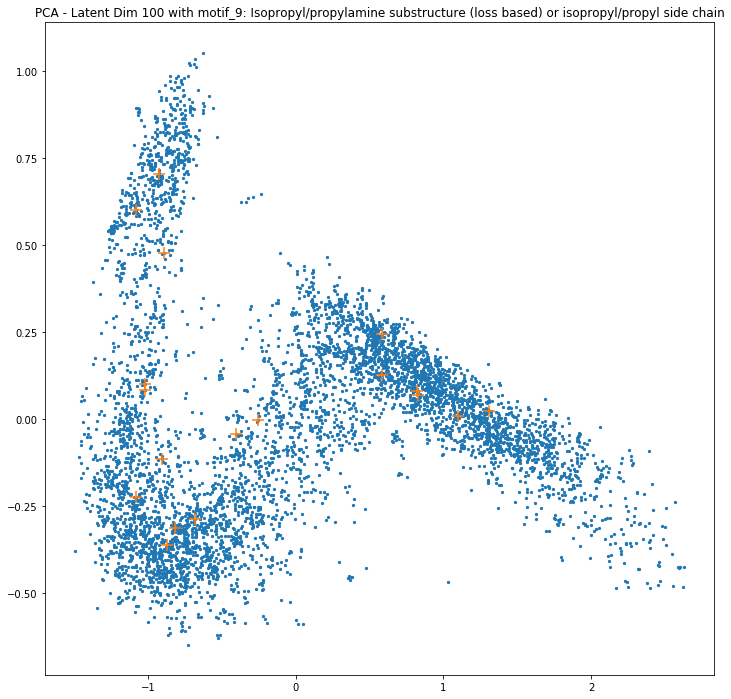

[383, 517, 555, 622, 943, 990, 1013, 1123, 1436, 1599, 1633, 2691, 2928, 3742, 4008, 4633, 4641, 4796, 4950, 5012, 5101, 5185, 5435, 5674, 5769]


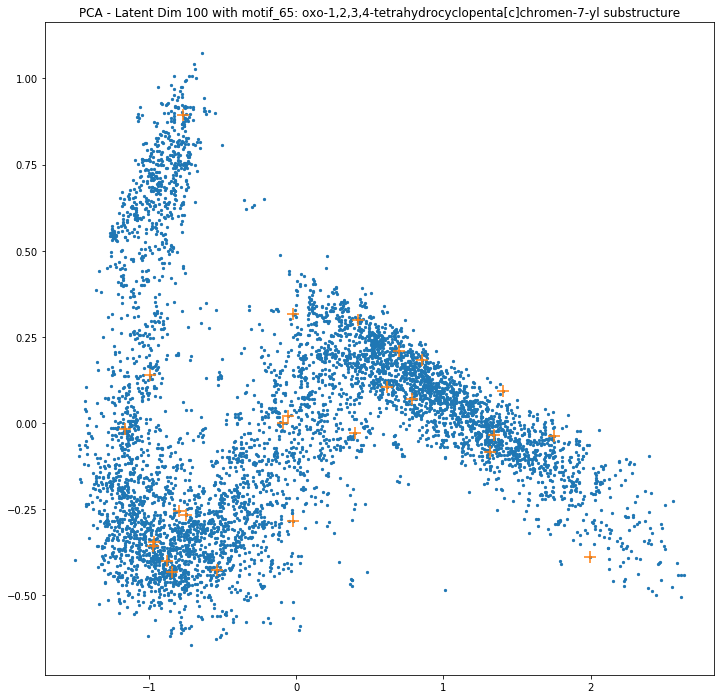

[277, 391, 800, 986, 1087, 1297, 1314, 1444, 1498, 1794, 1958, 2284, 2493, 2565, 2598, 2773, 2915, 3085, 3089, 3095, 3360, 3365, 3424, 3477, 3672, 3687, 3958, 4222, 4428, 4458, 4483, 4823, 4917, 4982, 4992, 5172, 5243, 5498, 5707]


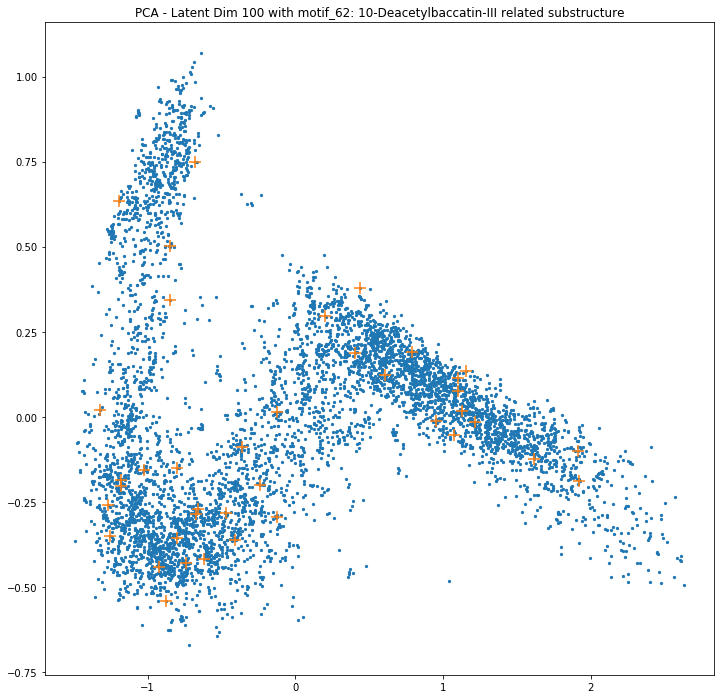

[198, 317, 369, 416, 1028, 1058, 1079, 1594, 1829, 1853, 1899, 2172, 2450, 2776, 2975, 3104, 3346, 3519, 3564, 3569, 3651, 4094, 4229, 4629, 4767, 4958, 5036, 5118, 5558, 5606]


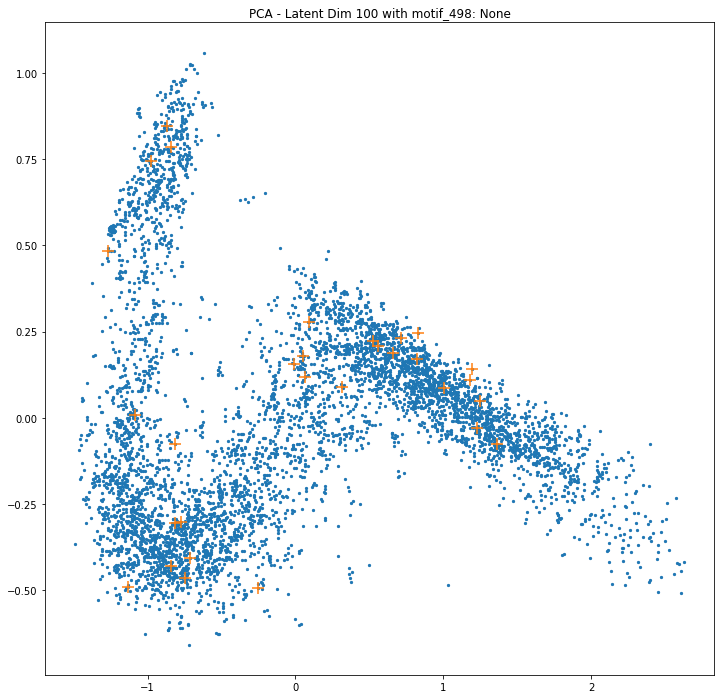

[233, 235, 261, 297, 505, 692, 697, 902, 1027, 1217, 1282, 1451, 1476, 1602, 1741, 1859, 2010, 2054, 2321, 2649, 2899, 3281, 3362, 3875, 4158, 4520, 4754, 4758, 4787, 5351, 5415]


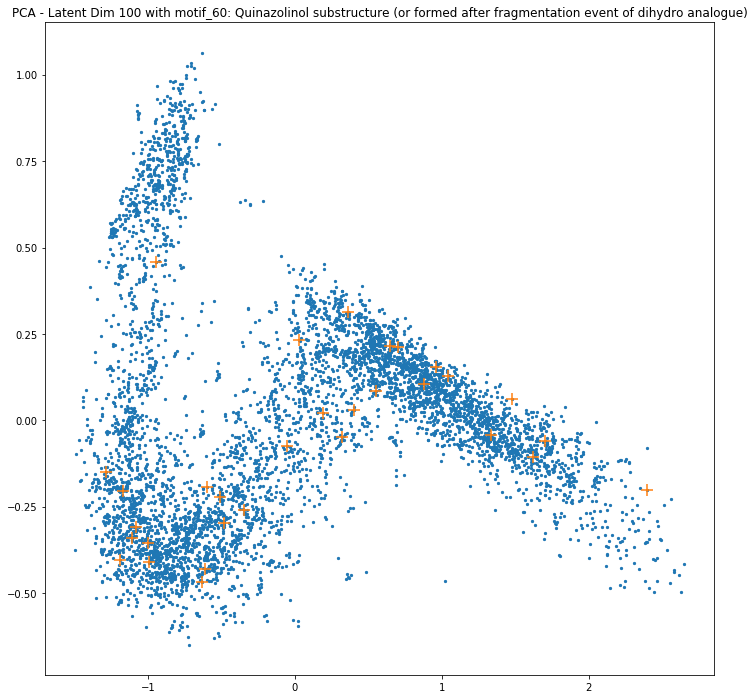

In [49]:
for k,v in test_dict.items():
    visualize_data_with_motifname(k, gnps_doc_data, input_array, threshold = 0.3, annotation = v)

In [50]:
%matplotlib notebook

[10, 12, 139, 159, 262, 496, 551, 637, 718, 849, 1020, 1045, 1135, 1546, 1885, 1921, 2066, 2957, 2977, 3118, 3331, 3480, 4285, 4297, 4437, 4838, 5008, 5366]
pca_comp=50 tsne_comp=2 tsne_perplexity=30.000000 tsne_lr=750.000000


<IPython.core.display.Javascript object>


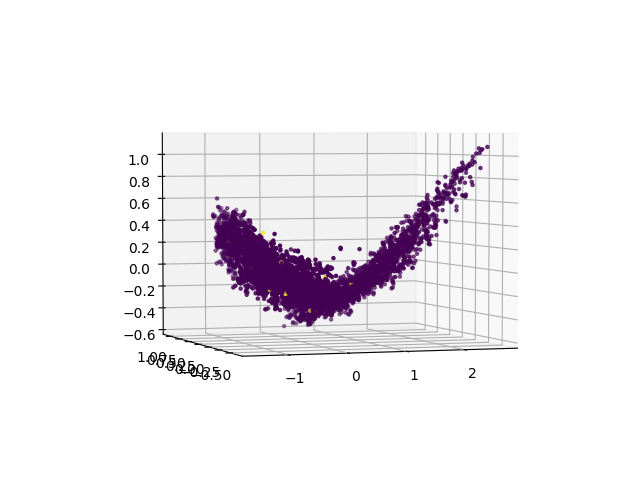

In [51]:
visualize_data_with_motifname_3d("motif_1", gnps_doc_data, input_array, threshold = 0.3)